# Environment

In [1]:
!cd ../&& pip install . | tail -n 3 &&cd -

    Uninstalling TEXTURElib-1.0:
      Successfully uninstalled TEXTURElib-1.0


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 3
from TX import upf, bcc_rolling_fiber, sym
import numpy as np
from matplotlib.gridspec import GridSpec
#from shapely import geometry
#from shapely.geometry import Point, Polygon
import scipy
import matplotlib
from scipy.interpolate import griddata
plt=matplotlib.pyplot
#vector_ang=bcc_rolling_fiber.vector_ang
#projection=upf.projection
#get_icsym=sym.get_icsym

def gen_fig(nrows=3,ncols=3,colsize=2.5,rowsize=2.,**kwargs):
    gs=GridSpec(nrows=nrows,ncols=ncols,**kwargs)
    fig=plt.figure(figsize=(colsize*ncols,rowsize*nrows))
    axes=np.empty((nrows,ncols),dtype='object')
    for i in range(nrows):
        for j in range(ncols):
            ax=fig.add_subplot(gs[i,j])
            axes[i,j]=ax
    return fig,axes

In [3]:
# !cd ../&& pip install . | tail -n 3 &&cd -

#kw=dict(miller=[1,1,1],fnsx='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/eddq.sx')
kw=dict(miller=[1,0,-1,2],fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx')
kw=dict(miller=[1,1,-2,2],fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx')
kw=dict(miller=[0,0,1],fnsx='/Users/youngung/repo/evpsc/examples/ex12_dd/uranium/uranium_dd_test.sx')
#!cd ../&& pip install . | tail -n 3 &&cd -
sym.calc_cvec(**kw)

array([0., 0., 1.])

## Resampling using griddata


nsymop in cells_pf: 12
Elapsed time for calling cells_pf:          44 [ ms]
nsymop in cells_pf: 12
Elapsed time for calling cells_pf:          46 [ ms]
nsymop in cells_pf: 12
Elapsed time for calling cells_pf:          44 [ ms]
(x,y): ((0.0, 0.0)), loc: (0.0, -0.1)

(x,y): ((1.0, 0.0)), loc: (1.0, -0.1)

(x,y): ((0.8660254037844387, 0.49999999999999983)), loc: (0.8660254037844387, 0.5999999999999999)
Elapsed time for calling cells_pf:          38 [ ms]

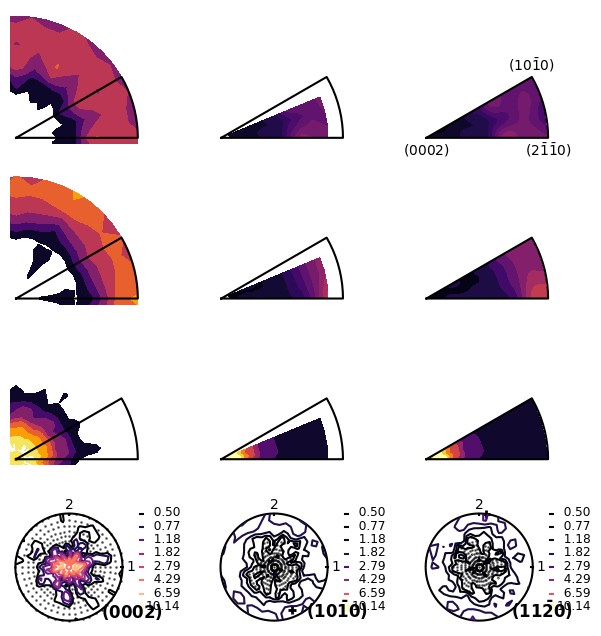

In [4]:
if True:
    filename='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/AZ31_500.tex'
    grs=np.loadtxt(filename,skiprows=4)
    fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx'
    csym, cdim, cang = sym.read_fnsx(fnsx)
#    a=[0,0,0,2];b=[1,0,-1,0];c=[2,-1,-1,0]
    a=[0,0,0,2];b=[2,-1,-1,0];c=[1,0,-1,0]
    cpoles=[[0,0,0,2],[1,0,-1,0],[1,1,-2,0]]
if False:
    a=[0,0,1];b=[1,0,1];c=[1,1,1] ## boundary
    fnsx='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/eddq.sx'
    csym, cdim, cang = sym.read_fnsx(fnsx)
    filename='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/EDDQ100'
    grs=np.loadtxt(filename,skiprows=4)
    cpoles=[[1,0,0],[1,1,0],[1,1,1]]
if False:
    a=[0,0,1];b=[1,0,0];c=[0,1,0] ## boundary
    fnsx='/Users/youngung/repo/evpsc/examples/ex12_dd/uranium/uranium_dd_test.sx'
    csym,cdim,cang=sym.read_fnsx(fnsx)
    filename='/Users/youngung/repo/evpsc/examples/ex01_elast/U_clock.tex'
    grs=np.loadtxt(filename,skiprows=4)    
    cpoles=[[1,0,0],[0,1,0],[1,0,1]]    
    
orders=[1,10]
poles=[[1,0,0],[0,1,0],[0,0,1]] ## inverse poles
fig,axes=gen_fig(nrows=len(poles)+1,ncols=len(orders)+1)#,rowsize=1.0)
dth=7.5; dph=7.5
mypf=upf.polefigure(grains=grs[:,:],csym=csym,cang=cang,cdim=cdim)
triangle=upf.get_ipf_boundary(fnsx=fnsx,a=a,b=b,c=c,nres=10)
circle=upf.__circle__()
for ip, pole in enumerate(poles):
    x,y,arr=mypf.pf_new(
        axs=axes[ip,0:1],cmap='inferno',mode='fill',
        poles=[pole],proj='ipf',dth=dth,dph=dph,mn=0,mx=5) ## sample axis 1
    for i, order in enumerate(orders):
        refined=scipy.ndimage.zoom(arr.T,order)
        refined[refined<0]=0.
        x_,y_=upf.xy_grid_from_shape(refined.T.shape)
        if True:
            mask=upf.gen_mask(triangle,shape=x_.shape,x=x_,y=y_)
            refined=np.ma.array(refined.T,mask=mask)
        else:
            refined=refined.T
        cnt=axes[ip,1+i].contourf(x_,y_,refined,vmin=0,vmax=5,cmap='inferno')
        #if ip==2: plt.colorbar(cnt)
## deco
for i, ax in enumerate(axes[:-1,:].flatten()):
    ax.set_axis_off()
    ax.plot(*triangle,zorder=10,c='k')
    ax.set_aspect('equal')
    #ax.plot(*upf.__circle__(),'-k')
for i, ax in enumerate(axes[:-1,:].flatten()):
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)

for j, miller in enumerate([a,b,c]):
    x,y=upf.projection(-sym.calc_cvec(miller=miller,fnsx=fnsx))
    t=''
    for i, v in enumerate(miller):
        #if v>0: t='%i'%v
        if v<0: tx=r'\bar{%i}'%-v
        else: tx='%i'%v
        t=f'{t}%s'%tx
    t=rf'$({t})$'
    if j<2 : loc=(x,y-0.1)
    if j==2: loc=(x,y+0.1)
    print(f'\n(x,y): ({x,y}), loc: {loc}')
    axes[0,-1].text(*loc,t,va='center',ha='center')

## plot pole figures
mypf.pf_new(axs=axes[-1,:],poles=cpoles,dth=dth,dph=dph,csym=csym,cang=cang,cdim=cdim)